In [8]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [110]:
def finDif(omega,f,n,bc):
    """
    Return the mass matrix for the finite difference approximation of the prblem -u_{xx}(x) = f(x).
    
    Parameters
    ----------
    omega : list
        Interval of the problem. It is a list of two elements, where omega[0] is the lower bound of the interval and
        omega[1] is the upper bound of the interval.
    f : function
        Forcing function of the problem
    n : integer
        Number of discretization points
    bc : list
        Boundary conditions of the problem. It is a list of two elements containing the values of the boundary conditions
        
    Returns
    -------
    out : tuple
        Tuple containing the matrix and the known-term vector
    """
    
    A = zeros((n,n))
    b = zeros(n)
    h = (omega[1] - omega[0]) / (n - 1)
    discr_points = [i * h for i in range(n)]
    
    b[0], b[1] = bc
     
    A = diag(ones(n-2),-2) + diag(-16*ones(n-1),-1) + diag(30*ones(n)) + diag(-16*ones(n-1),1) + diag(ones(n-2),2)
    
    f = vectorize(f)
    b[1:n-1] = f(discr_points[1:n-1])
    
    return A / (12*(h)**2), b

Call the function using:

In [97]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

A[0,:] = zeros(n)
A[-1,:] = zeros(n)
A[0,0] = A[-1,-1] = 1

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [98]:
def LU(A):
    """
    Return the LU factorization of the system matrix A.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix for which to compute the factorization.
        
    Returns
    -------
    out : tuple
        Tuple containing two elements: the lower-triangular matrix and the upper-trinagular matrix computed by the
        LU factorization.
    """
    
    n = len(A)
    L = eye(n, dtype=float)
    U = A.copy().astype(float)
    
    for k in range(n):
        L[k+1:n,k] = U[k+1:n,k] / U[k,k]
        for i in range(k+1,n):
            for j in range(k,n):
                U[i,j] -= L[i,k] * U[k,j]
    return L, U

L, U = LU(A)

In [57]:
def cholesky(A):
    """
    Return the Cholesky factorization of the system matrix A.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix for which to compute the factorization.
        The matrix must be symmetric and positive definite.
        
    Returns
    -------
    out : tuple
        Tuple containing two elements: the lower-triangular matrix and the upper-trinagular matrix computed by the
        Cholesky factorization (one is the transpose of the other).
    """
    
    assert allclose(A, A.T), "The matrix is not symmetric"
    
    n = len(A)
    L = zeros((n,n), dtype=float)
    
    L[0,0] = A[0,0]**.5
    for j in range(1,n):
        for i in range(0,j):
            L[i,j] = (A[j,i] - sum(L[:i,j]*L[:i,i])) / L[i,i]
    
        L[j,j] = (A[j,j] - sum(L[:j,j]**2))**.5

    return L.transpose(), L

HT, H = cholesky(A)

allclose(A,HT.dot(H))

True

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [75]:
def L_solve(L,rhs):
    x = zeros_like(rhs).astype(float)
    n = len(rhs)
    
    x[0] = rhs[0] / L[0,0]
    for i in range(1,n):
        x[i] = (rhs[i] - sum(L[i,:i]*x[:i])) / L[i,i]
    
    return x

In [59]:
def U_solve(U,rhs):
    x = zeros_like(rhs).astype(float)
    n = len(rhs)
    
    x[-1] = rhs[-1] / U[-1,-1]
    for i in range(n-1,-1,-1):
        x[i] = (rhs[i] - sum(U[i,i+1:]*x[i+1:])) / U[i,i]
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

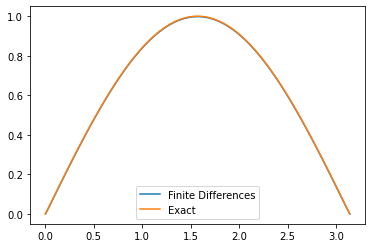

In [101]:
def solve_system(A,b):
    L, U = LU(A)
    y = L_solve(L, b)
    x = U_solve(U, y)
    
    return x

u = solve_system(A,b)
allclose(A.dot(u), b)
discr_points = linspace(omega[0],omega[1],n)
x = linspace(omega[0],omega[1])
plot(discr_points,u, label="Finite Differences")
plot(x,f(x), label="Exact")
_ = legend()

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

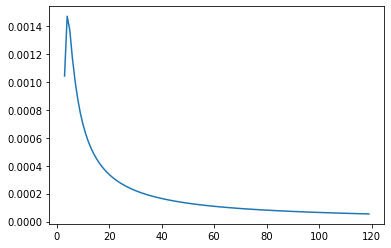

In [128]:
omega = [0,1]
f = lambda x : x*(1. - x)
bc = [0,0]
exact = lambda x : x**4/12 - x**3/6 + x/12

errors = []

for n in range(3,120):
    A,b = finDif(omega,f,n,bc)
    A[0,:] = zeros(n)
    A[-1,:] = zeros(n)
    A[0,0] = A[-1,-1] = 1
    
    u = solve_system(A,b)
    discr_points = linspace(omega[0],omega[1],n)
    
    error = max(abs(exact(discr_points) - u))
    errors.append(error)

plot(range(3,120),errors)
#x = linspace(omega[0],omega[1])
#plot(discr_points,u, label="Finite Differences")
#plot(x,exact(x), label="Exact")
#_ = legend()

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [ ]:
def condNumb(A):
    pass #TODO
    return condNu

Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [ ]:
def conjugate_gradient(A, b, P, nmax=len(A), eps=1e-10):
    pass #TODO

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


In [ ]:
#TODO

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [ ]:
#TODO

Compute the inverse of the matrix A exploiting the derived LU factorization

In [ ]:
#TODO

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [ ]:
#TODO